<a href="https://colab.research.google.com/github/tirsky/astroalert/blob/master/BL_dark_bias_flat_white.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import glob
from astropy.io import fits
from scipy.ndimage import interpolation as interp

from skimage.feature.register_translation import (register_translation, _upsampled_dft)


## This turns off warnings: not a great way to code
## But when we show the images, sometimes we're taking the logarithm of zero and it doesn't like that
## Which would matter if we were doing math, but we're just taking a look at images, so we can ignore it. 
import warnings
warnings.filterwarnings('ignore')

In [3]:
## function to plot an image cube
## for this code a "cube" means a stack of image data arrays

def plot_grid(datacube,imagenames):
    no_A = len(datacube) ## number of individual images in the cube
    xplots = int(np.around(np.sqrt(no_A))) ## number of image grid columns
    yplots = xplots + 1 ## number of image grid rows--sometimes there are one fewer, but that's okay

#     print no_A, xplots, yplots ## this line is for troubleshooting
    
    gs = gridspec.GridSpec(yplots, xplots) ## define the image grid
    plt.figure(figsize=(15,15)) ## set the figure size
    for i in range(no_A): 
        ## plots each individual image within the image grid: 
        B = datacube[i]
        plt.subplot(gs[i])
        plt.imshow(np.log10(B), origin='lower', cmap='gray')
        plt.title(imagenames[i])

In [4]:
ls *.fits 

bias.fits  bl-lac.fits  dark.fits  ff.fits


In [5]:
## make a list of the bias files:
bias_list = glob.glob('bias*')
# print biaslist ##this line is for troubleshooting

## make a list of v-filter flat images:
vflat_list = glob.glob('ff*')
# print vflatlist ## for troubleshooting

## make a list of raw science images:
## in this case, the raw science frames are v-band images of the orion nebula (messier 42)
bl_lac_list = glob.glob('bl-lac*fits')
# print bl_lac_list ## for troubleshooting

## now put all the lists together for a masterlist of all the images:
all_images_list = bias_list + vflat_list + bl_lac_list

In [6]:
all_images_list

['bias.fits', 'ff.fits', 'bl-lac.fits']

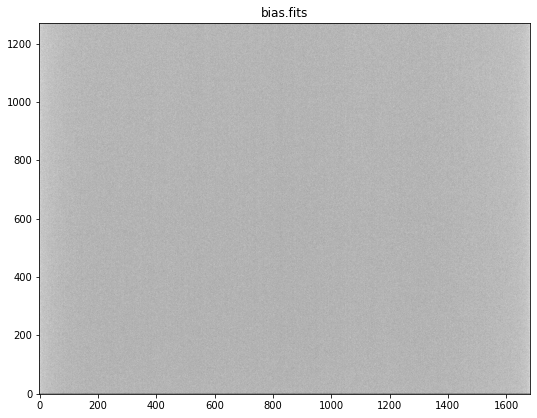

In [10]:
raw_image_data = {}
for image_name in all_images_list: raw_image_data[image_name] = fits.getdata(image_name)

# for image in all_images_list: print raw_image_data[image].shape ##for troubleshooting
## (check to make sure they're all the same size)

## create an array of bias images
biascube = np.stack([raw_image_data[bias_frame] for bias_frame in bias_list],axis=0)
#print biascube.shape ## this line is for troubleshooting

## show the bias image(s)
plot_grid(biascube,bias_list)

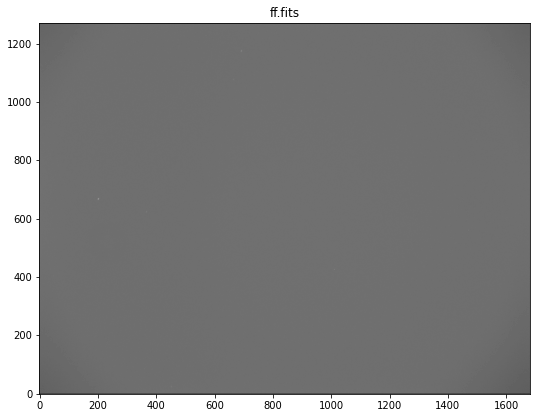

In [48]:


## create an array of v-flat images
vflatcube = np.stack([raw_image_data[vflat_frame] for vflat_frame in vflat_list],axis=0)

## create an array of raw Bl Lac images
bl_laс_cube = np.stack([raw_image_data[science_frame] for science_frame in bl_lac_list],axis=0)



## show the v-flat image(s)
plot_grid(vflatcube,vflat_list)



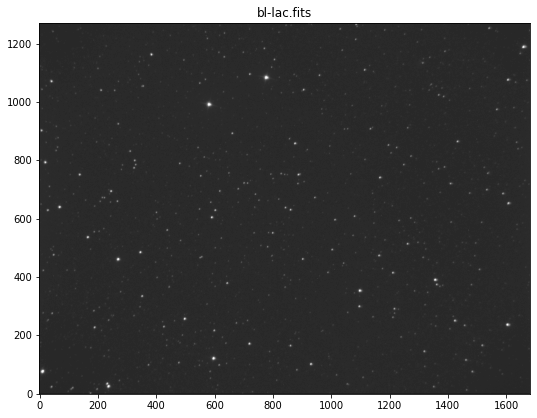

In [49]:
## show the BL-lac image(s)
plot_grid(bl_laс_cube,bl_lac_list)

In [50]:
## average-combine the biases into a single master image with lower noise (exactly the same process for darks)

master_bias = np.average(biascube, axis=0) ## to combine with an average

# master_bias = np.median(biascube, axis=0) ## to median combine them instead

Text(0.5, 1.0, 'Master Bias')

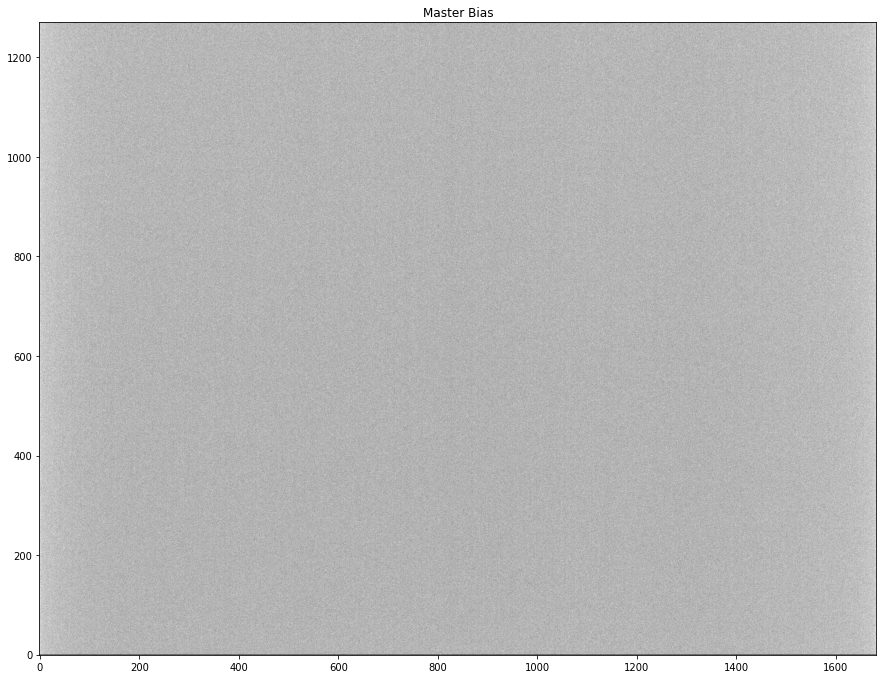

In [51]:
plt.figure(figsize=(15,15)) 
plt.imshow(np.log10(master_bias), origin='lower', cmap='gray');
plt.title('Master Bias')

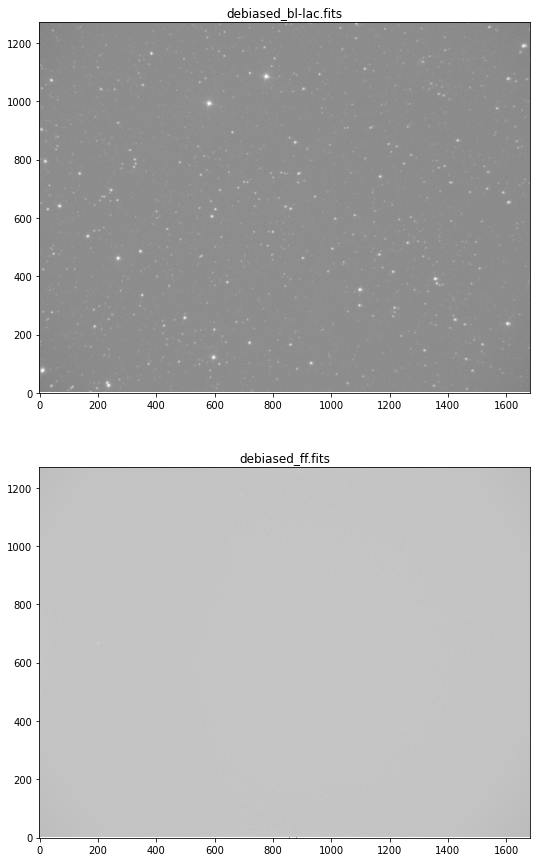

In [52]:
# filneames of flats and science frames that have not yet been bias-subtracted: 
debias_list_in = bl_lac_list + vflat_list
#print debiaslist_in ## for troubleshooting

## filenames for the corresponding bias-subtracted images:
debias_list_out = ['debiased_' + im for im in debias_list_in]


## subtract the master bias from each of the raw science & flat frames: 

debias_data_out = {} ## dictionary for the debiased images

for i in range(len(debias_list_in)):  
    debias_data_out[debias_list_out[i]] = raw_image_data[debias_list_in[i]] - master_bias

## python note: we're iterating over an integer, through lists, and the lists were defined in the same order. 
## we wouldn't want to iterate through dictionaries this way because dictionaries are unordered. 

## create an array of debiased images
debiascube = np.stack([debias_data_out[image] for image in debias_list_out],axis=0)

## show the images: 
plot_grid(debiascube,debias_list_out)

Text(0.5, 1.0, 'debiased_bl-lac.fits')

<Figure size 432x288 with 0 Axes>

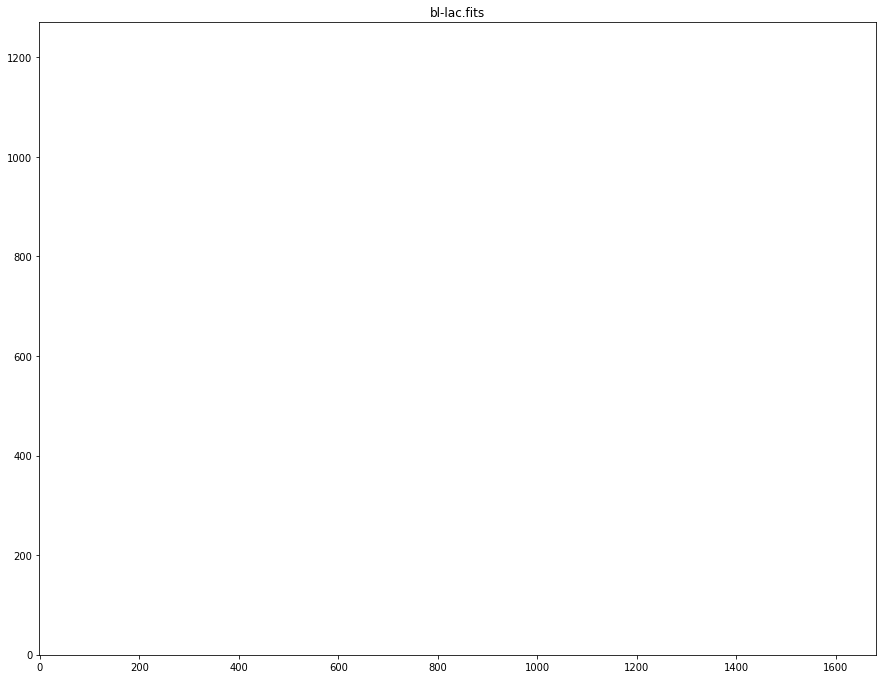

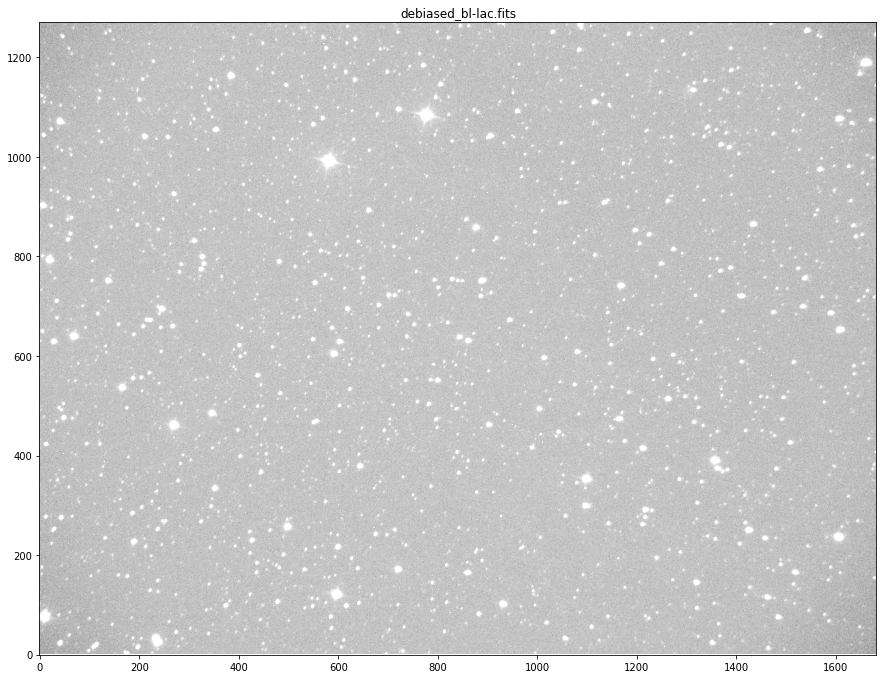

In [53]:


## this results in "debiased" science & flat frames
## for one of the science frames, the difference is shown here--top is the raw image, 
## bottom is the debiased image

im = 0  ## the image we're looking at. Bl Lac is 0 through 0, the flats are 0 through 0

## these values are the maximum and minumum pixel values mapped to different grays 
## where min gets shown as black and max as white
## all the plots shown are in log base 10, so the actual pixel values aren't really 1.5-3 or so
## but those are the values after we take the logarithm in this case. 
graymin = 1.5
graymax = 3

plt.figure(1);
plt.figure(figsize=(15,15)) ;
plt.imshow(np.log10(raw_image_data[debias_list_in[im]]), origin='lower', cmap='gray', vmin=graymin, vmax=graymax);
plt.title(debias_list_in[im])

plt.figure(2);
plt.figure(figsize=(15,15)) ;
plt.imshow(np.log10(debias_data_out[debias_list_out[im]]), origin='lower', cmap='gray', vmin=graymin, vmax=graymax);
plt.title(debias_list_out[im])



In [54]:
## first we need a list of JUST the debiased flat images to work with: 
debias_vflat_list = ['debiased_' + image for image in vflat_list] 

## create an array of debiased v-flat images 
vflatcube = np.stack([debias_data_out[vflat_frame] for vflat_frame in debias_vflat_list],axis=0)

## average the images in the stack
master_vflat = np.average(vflatcube, axis=0)

Text(0.5, 1.0, 'Master Flat')

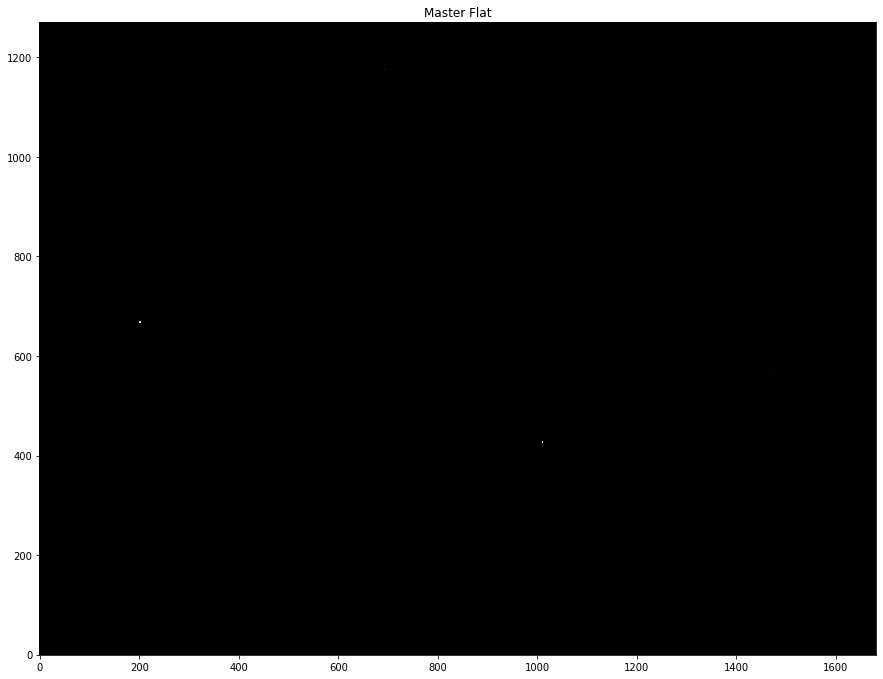

In [55]:
## here's the master flat: 
plt.figure(figsize=(15,15))
plt.imshow((master_vflat), origin='lower', cmap='gray', vmin=5250, vmax=6000)
plt.title('Master Flat')

## it's not shown in the same log scale as everything else so that we can see the flatfield variations better. 


In [56]:
print ('master flat median: ' + str(np.median(master_vflat)) + " counts")
print ('master flat mean: ' + str(np.mean(master_vflat)) + " counts")
print ('master flat max value: ' + str(np.max(master_vflat)) + " counts")
print ('master flat min value: ' + str(np.min(master_vflat)) + " counts")

master flat median: 3613.0 counts
master flat mean: 3587.287919200008 counts
master flat max value: 42402.0 counts
master flat min value: -102.0 counts


In [57]:
normalized_master_vflat = master_vflat/np.mean(master_vflat)

In [58]:


## common sense statistics check: 

print ('normalized master flat median: ' + str(np.median(normalized_master_vflat)))
print ('normalized master flat mean: ' + str(np.mean(normalized_master_vflat)))
print ('normalized master flat max value: ' + str(np.max(normalized_master_vflat)))
print ('normalized master flat min value: ' + str(np.min(normalized_master_vflat)))



normalized master flat median: 1.007167554258016
normalized master flat mean: 1.0
normalized master flat max value: 11.820071584735233
normalized master flat min value: -0.028433736654945377


Text(0.5, 1.0, 'Normalized Master Flat')

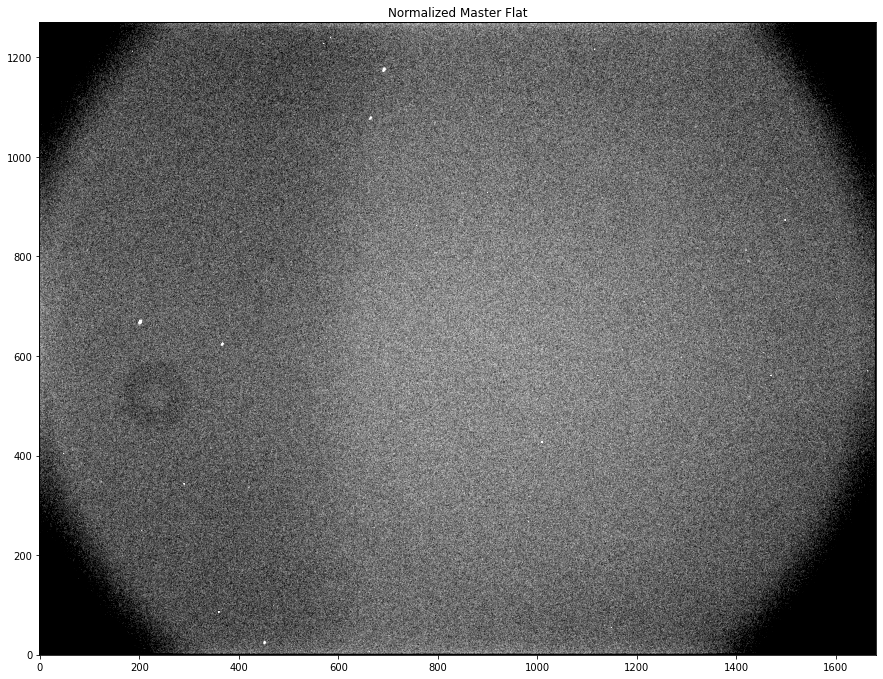

In [59]:


## normalized master flat: 
plt.figure(figsize=(15,15))
plt.imshow((normalized_master_vflat), origin='lower', cmap='gray', vmin=.95, vmax=1.1)
plt.title('Normalized Master Flat')



In [75]:


## we'll start with a list of the debiased bl_lac images: 
debias_bl_lac_list = ['debiased_' + im for im in bl_lac_list]
print(debias_bl_lac_list) ## this line is for troubleshooting
plt.figure(1)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(debias_bl_lac_list[0]), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(1) Raw Science Image: ' + im1)
## and we'll make a corresponding list to name the flattened images: 
flat_debias_bl_lac_list = ['flattened_' + im for im in debias_bl_lac_list]
print(flat_debias_bl_lac_list) ## this line is for troubleshooting

## create an empty dictionary to populate with the completely corrected science frames: 
flat_debias_data_out = {} 

## and populate the dictionary with each corrected image
## where the dictionary keys = the images in flat_debias_m42_list
## we're iterating over an integer here again because the lists match up
for i in range(len(debias_bl_lac_list)): 
    flat_debias_data_out[flat_debias_bl_lac_list[i]] = \
    debias_data_out[debias_bl_lac_list[i]]/normalized_master_vflat



['debiased_bl-lac.fits']


TypeError: ignored

<Figure size 432x288 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

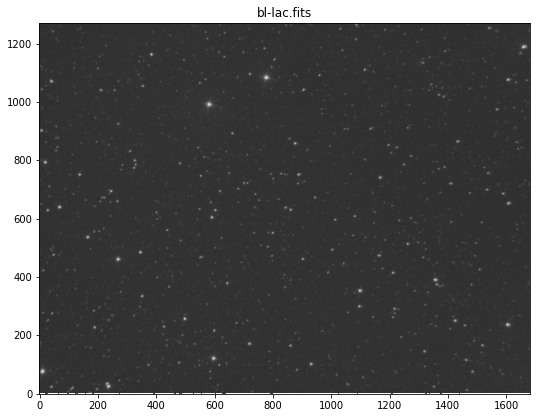

In [61]:


## create an array of corrected M42 images
bl_lac_cube = np.stack([flat_debias_data_out[science_frame] for science_frame in flat_debias_bl_lac_list],axis=0)
# print bl_lac_cube ## this line is for troubleshooting
# bl_lac_cube.shape ## this line is for troubleshooting

## show the images: 
plot_grid(bl_lac_cube,bl_lac_list)



flattened_debiased_bl-lac.fits


Text(0.5, 1.0, '(3) Flatfielded & Debiased Image: flattened_debiased_bl-lac.fits')

<Figure size 432x288 with 0 Axes>

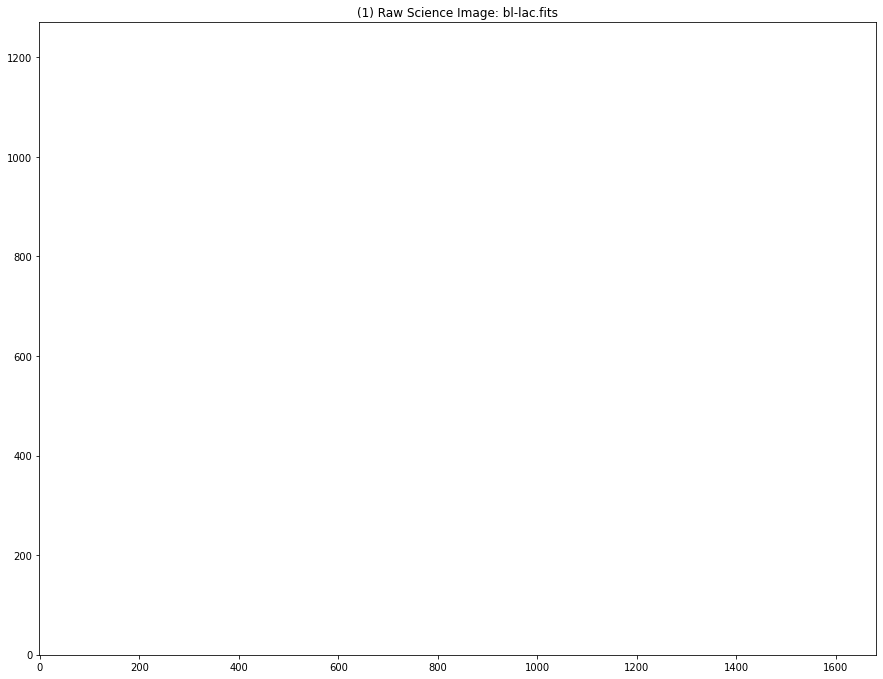

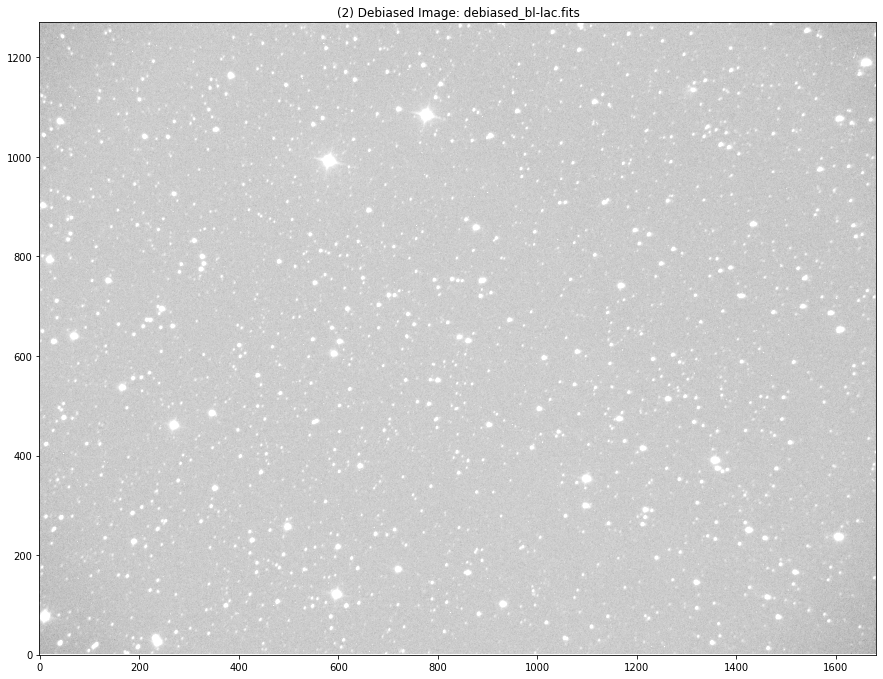

In [104]:
## so if we compare the initial raw science frame (1) to a debiased (2) and a flatfield & bias-corrected frame (3) 
## we can see the progression in lessening noise

## grayscale mapping min/max values: 
graymin = 1.25
graymax = 3

im = 0  ## the image we're looking at. there are 1 images of bl_lac, indexed 0 through 0

## (1) raw image
im1 = bl_lac_list[im]
data_im1 = raw_image_data[im1]
## (2) debiased image
im1_d = debias_bl_lac_list[im]
data_im1_d = debias_data_out[im1_d]

## (3) flattened and debiased image
im1_d_f = flat_debias_bl_lac_list[im]
print(im1_d_f)
data_im1_d_f = flat_debias_data_out[im1_d_f]

plt.figure(1)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(1) Raw Science Image: ' + im1)

plt.figure(2)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1_d), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(2) Debiased Image: ' + im1_d)

plt.figure(3)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1_d_f), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(3) Flatfielded & Debiased Image: ' + im1_d_f)

In [103]:


## array of images + average combine: 
bl_lac_cube = np.stack(flat_debias_data_out.values(),axis=0)
bl_lac_stacked = np.average(bl_lac_cube, axis=0)

## plotting: 
plt.figure(1);
plt.figure(figsize=(15,15));
plt.title('I-Band bl_lac: Stacked But Not Aligned');
plt.imshow(np.log10(bl_lac_stacked), origin='lower', cmap='gray', vmin=1.5, vmax=3);



<Figure size 432x288 with 0 Axes>

In [102]:


## choose an image to define as zero shift:
zero_shift_image = flat_debias_bl_lac_list[0]
print(zero_shift_image)
## find all shifts for other images: 
imshifts = {} # dictionary to hold the x and y shift pairs for each image
for image in flat_debias_bl_lac_list: 
    ## register_translation is a function that calculates shifts by comparing 2-D arrays
    result, error, diffphase = register_translation(
        flat_debias_data_out[zero_shift_image], 
        flat_debias_data_out[image], 1000)
    imshifts[image] = result
    
print(imshifts) ## for troubleshooting



flattened_debiased_bl-lac.fits
{'flattened_debiased_bl-lac.fits': array([-0.75, -0.75])}


In [100]:
## new list for shifted image names: 
print(flat_debias_bl_lac_list)
shifted_bl_lac_list = ['shifted_' + im for im in flat_debias_bl_lac_list]

## new dictionary for shifted image data: 
shifted_bl_lac_data = {}
for i in range(len(shifted_bl_lac_list)):
    ## interp.shift is the function doing the heavy lifting here,
    ## it's reinterpolating each array into the new, shifted one
    shifted_bl_lac_data[shifted_bl_lac_list[i]] = interp.shift(
        flat_debias_data_out[flat_debias_bl_lac_list[i]], 
        imshifts[flat_debias_bl_lac_list[i]])

['flattened_debiased_bl-lac.fits']


In [105]:

## array of aligned arrays: 
bl_lac_cube  = np.stack(shifted_bl_lac_data.values(),axis=0)
## average combined final image: 
bl_lac_stacked = np.average(bl_lac_cube, axis=0)
bl_lac_stacked.shape



(1271, 1682)

<Figure size 432x288 with 0 Axes>

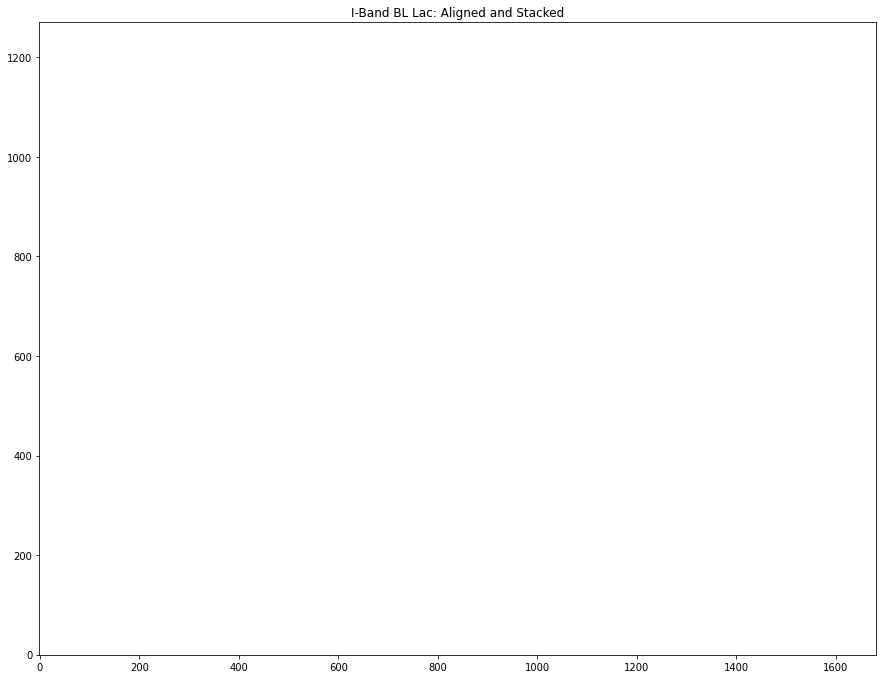

In [108]:
## show the final image array as an image: 
plt.figure(1)
plt.figure(figsize=(15,15));
plt.title('I-Band BL Lac: Aligned and Stacked');
plt.imshow(np.log10(bl_lac_stacked), origin='lower', cmap='gray', vmin=1.5, vmax=3)

Text(0.5, 1.0, '(4) Final Aligned & Stacked Image')

<Figure size 432x288 with 0 Axes>

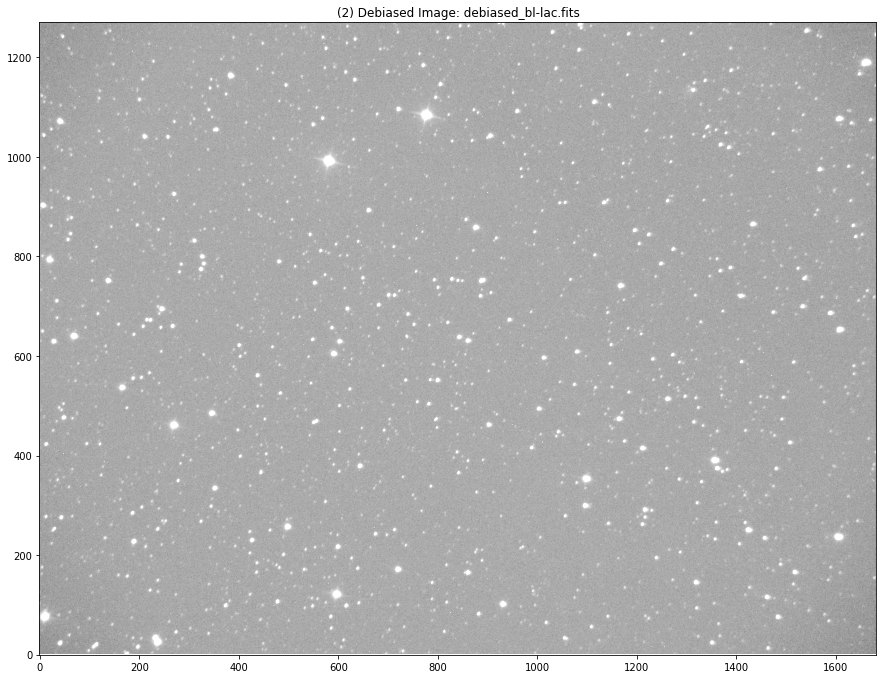

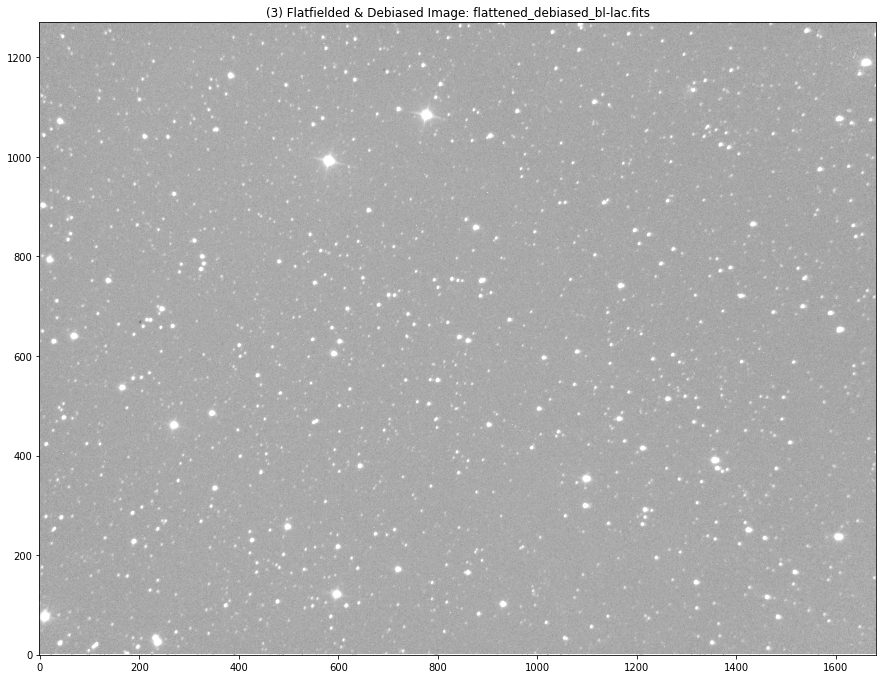

In [110]:
## 1st image is raw science frame
## 2nd image has been debiased (science - bias)
## 3rd image has been flatfield-corrected ((science - master_bias)/(normalized_master_flat))
## 4th image has been aligned and stacked (sum(shifted((science - master_bias)/(normalized_master_flat)))

## grayscale mapping min/max values: 
graymin = 1.45
graymax = 3.25

im = 0  ## the image we're looking at. there are 1 images of Bl Lac, indexed 0 through 0

## (1) raw image
im1 = bl_lac_list[im]
data_im1 = raw_image_data[im1]

## (2) debiased image
im1_d = debias_bl_lac_list[im]
data_im1_d = debias_data_out[im1_d]

## (3) flattened and debiased image
im1_d_f = flat_debias_bl_lac_list[im]
data_im1_d_f = flat_debias_data_out[im1_d_f]

plt.figure(1)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(1) Raw Science Image: ' + im1)

plt.figure(2)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1_d), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(2) Debiased Image: ' + im1_d)

plt.figure(3)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1_d_f), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(3) Flatfielded & Debiased Image: ' + im1_d_f)

plt.figure(4)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(bl_lac_stacked), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(4) Final Aligned & Stacked Image')